In [1]:
import random
import pickle
import sklearn
import itertools
import numpy as np
import matplotlib.pyplot as plt

from feature_extractor import *
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

%matplotlib inline

## Flag 1

In [2]:
with open("matrix.pickle","rb") as f:
    matrix = pickle.load(f)

In [3]:
# adapted from sklearn official website
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

def plot_confusion_matrix(cm,
                          normalize=False,
                          title='Confusion matrix',
                          classes=["True Edge","Fake Edge"],
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
def feature_generator(pairs):
    
    X = []
    for datum in tqdm(pairs):
        a, b = datum

        # node feature
        a_in = indegree(a, matrix)
        a_out = outdegree(a, matrix)
        b_in = indegree(b, matrix)
        b_out = indegree(b, matrix)

        # neighbouring feature
        neighbour = common_neighbour(a, b, matrix)
        jac = jaccard(neighbour, a, b, matrix)
        dice = dice_idx(neighbour, a, b, matrix)
        p_a = pref_attach(a, b, matrix)
        cos = cosine_sim(neighbour, p_a)
        lhn = LHN(neighbour, p_a)
        adar = adamic_adar(a, b, matrix)
        ra = resource_allocation(a, b, matrix)
        reverse = reverse_link(a, b, matrix)
        hp = hub_promoted(neighbour, a, b, matrix)
        hd = hub_depressed(neighbour, a, b, matrix)

        # path feature
        #sim_r = sim_rank(a, b, matrix, 0)

        #flow1, flow2, flow3 = propflow(a, b, matrix)
        flow1, flow2 = propflow3(a, b, matrix)

        X.append([a_in,a_out,b_in,b_out,neighbour,jac,dice,p_a,cos,lhn,adar,reverse,hp,hd,flow1,flow2])
        
    return X

## Training

In [22]:
data = np.load("data.npy")

with open("rec_sim.pickle","rb") as f:
    rec_sim = pickle.load(f)

# append recommondation cosine similarity
data = data.tolist()
for i in range(len(data)):
    data[i].insert(-1,rec_sim[data[i][0]])
data = np.array(data)

train, test = train_test_split(data[:,1:], train_size=0.8)
X_train, y_train = train[:,:-1], train[:,-1]
X_test, y_test = test[:,:-1], test[:,-1]

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [23]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, verbose=1)
rf.fit(X_train, y_train)
print(rf.score(X_test, y_test))

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


0.8495


In [24]:
rf.feature_importances_

array([0.09114564, 0.11971713, 0.07181809, 0.07023915, 0.00400258,
       0.00374774, 0.00525714, 0.00686079, 0.01051177, 0.01824084,
       0.00405471, 0.01595771, 0.01673061, 0.00507615, 0.08935831,
       0.1336809 , 0.33360073])

In [11]:
base = GradientBoostingClassifier()
parameters = {"learning_rate":[0.05,0.1,0.15,0.2,0.3],
              "max_depth":[2,3,5,7],
              "min_samples_leaf":[1,3,5]}
model = GridSearchCV(base, parameters, n_jobs=-1)
model.fit(X_train, y_train)
print(model.score(X_test, y_test))

0.7979274611398963


In [26]:
base = RandomForestClassifier(n_estimators=100)
parameters = {
    "max_depth":[9,11,13,15,17],
    "min_samples_leaf":[1,3,5],
    "min_samples_split":[2,4,6,8,10],
}
model = GridSearchCV(base, parameters, n_jobs=-1)
model.fit(X_train, y_train)
print(model.score(X_test, y_test))

0.85425


In [27]:
print(roc_auc_score(y_test, np.squeeze(model.predict_proba(X_test)[:,1])))

0.9361779908862137


In [28]:
(model.predict(X_test) == 0).sum()

2107

In [29]:
model.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=13, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [30]:
model.best_estimator_.feature_importances_

array([0.04496695, 0.05672548, 0.05955289, 0.06043752, 0.00462308,
       0.01094158, 0.00830413, 0.00630216, 0.02138198, 0.01632411,
       0.00330907, 0.0218792 , 0.02337896, 0.00679971, 0.12227007,
       0.139612  , 0.39319113])

## prepare submission

In [5]:
with open("test-public.txt","r") as f:
    test = f.readlines()

X_t = []
for l in test[1:]:
    temp = list(map(int, l.split()))
    X_t.append([temp[1], temp[2]])
print(len(X_t))

2000


In [6]:
X_t = np.array(feature_generator(X_t))

100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [1:53:06<00:00,  3.39s/it]


In [8]:
X_t.dump("Xt.npy")

In [18]:
X_t = np.load("Xt_.npy")

with open("rec_sim_test.pickle", "rb") as f:
    rec_sim_test = pickle.load(f)

In [19]:
X_t = X_t[:, :-1].tolist()

for i in range(len(X_t)):
    X_t[i].append(rec_sim_test[i+1])

X_t = np.array(X_t)
print(X_t.shape)

(2000, 17)


In [31]:
y_pred = model.predict(X_t)
(y_pred == 0).sum()

1120

In [32]:
y_pred_prob = model.predict_proba(X_t)

In [33]:
with open("pred_rf.csv","w") as f:
    f.write("Id,Prediction\n")
    for i in range(1,len(y_pred_prob)+1):
        f.write(str(i) + "," + str(y_pred_prob[i-1][1]) + "\n")

## xgboost

In [34]:
import xgboost

In [35]:
xgb = xgboost.XGBClassifier()
xgb.fit(X_train, y_train)
print(roc_auc_score(y_test, np.squeeze(xgb.predict_proba(X_test)[:,1])))

0.9388415129365356


In [36]:
y_pred = xgb.predict(X_t)
(y_pred == 0).sum()

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


1101

In [45]:
y_pred_prob = xgb.predict_proba(X_t)

with open("pred.csv","w") as f:
    f.write("Id,Prediction\n")
    for i in range(1,len(y_pred_prob)+1):
        f.write(str(i) + "," + str(y_pred_prob[i-1][1]) + "\n")

In [37]:
params = {"learning_rate":[0.1,0.15,0.2,0.25],
          "max_depth":[3,4,5,6,8,10],
          "subsample":[0.6,0.75,0.85,1],
          "colsample_bylevel":[0.6,0.75,0.85,1]}

base = xgboost.XGBClassifier(n_estimators=100)
xgb_ = GridSearchCV(base,params,n_jobs=-1,scoring='roc_auc',verbose=1)
xgb_.fit(X_train, y_train)
print("done!")

Fitting 3 folds for each of 384 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  6.6min finished


done!


In [38]:
xgb_.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.85)

In [116]:
scores = xgb_.best_estimator_.get_booster().get_score()
print(scores)

fnames = ['a in','a out','b in','b out',
          'common neighbour','jaccard','dice','preferential attachment','cosine',
          'lhn','adamic adar','reverse link','hub promoted','hub depressed',
          'propflow level2','propflow level3','recommendation']

mapped = {fnames[int(k[1:])]: v for k, v in scores.items()}
print(mapped)

{'f16': 237, 'f15': 164, 'f2': 227, 'f0': 138, 'f14': 95, 'f1': 179, 'f11': 29, 'f10': 36, 'f7': 42, 'f4': 9, 'f9': 13, 'f12': 15, 'f5': 5, 'f13': 5, 'f8': 7}
{'recommendation': 237, 'propflow level3': 164, 'b in': 227, 'a in': 138, 'propflow level2': 95, 'a out': 179, 'reverse link': 29, 'adamic adar': 36, 'preferential attachment': 42, 'common neighbour': 9, 'lhn': 13, 'hub promoted': 15, 'jaccard': 5, 'hub depressed': 5, 'cosine': 7}


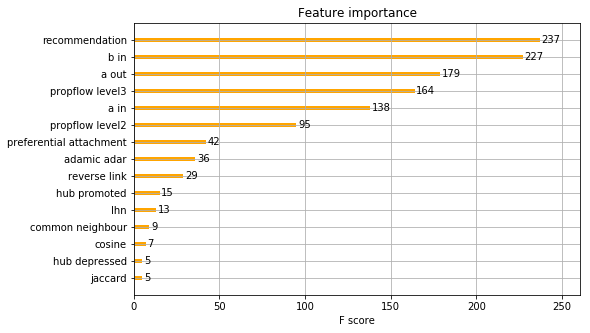

In [120]:
plt.rcParams["figure.figsize"] = (8,5)
ax = xgboost.plot_importance(mapped,importance_type="weight",ylabel=None,color="orange")
plt.show()

In [40]:
y_pred = xgb_.predict(X_test)
(y_pred == 0).sum()

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


2048

0.9428012890526544
Confusion matrix, without normalization
[[1735  237]
 [ 313 1715]]


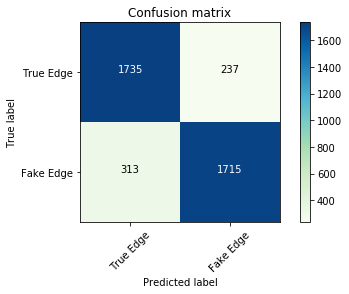

In [93]:
print(roc_auc_score(y_test, np.squeeze(xgb_.predict_proba(X_test)[:,1])))
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,cmap=plt.cm.GnBu)
plt.show()

In [42]:
y_pred_prob = xgb_.predict_proba(X_t)
with open("pred_xg.csv","w") as f:
    f.write("Id,Prediction\n")
    for i in range(1,len(y_pred_prob)+1):
        f.write(str(i) + "," + str(y_pred_prob[i-1][1]) + "\n")